In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import setigen as stg
from astropy import units as u
import blimpy as bl
from astropy.time import Time
import extract_signals as es

In [10]:
file_list = []
height_ratios = []
for i, row in es.DRIFTS.iterrows():
    filename = row['filename']
    full_path = f'{es.DATA_PREFIX}/{filename}'.replace('blcxx', 
                                                       es.META.loc[0]['node'])
    file_list.append(full_path)

    container = bl.Waterfall(full_path, load_data=False).container
    tchans = container.file_shape[0]
    dt = container.header['tsamp']
    height_ratios.append(tchans * dt)

stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_1421-490_S_2019-04-29T12:39:50.000.fil, freq lowest=982.0014991760254, highest=982.0034980773926
stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_1421-490_R_2019-04-29T12:46:00.000.fil, freq lowest=982.0014991760254, highest=982.0034980773926
stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_ProxCen_S_2019-04-29T13:02:35.000.fil, freq lowest=982.0014991760254, highest=982.0034980773926
stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_1421-490_S_2019-04-29T13:34:59.000.fil, freq lowest=982.0014991760254, highest=982.0034980773926
stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_ProxCen_S_2019-04-29T13:47:46.000.fil, freq lowest=982.0014991760254, highest=982.0034980773926
stax            INFO     Processing: /mnt_blpd2/datax/PKSUWL/blc03/PKSUWL/blc03_1934-638_S_2019-04-29T14:21:18.000.fi

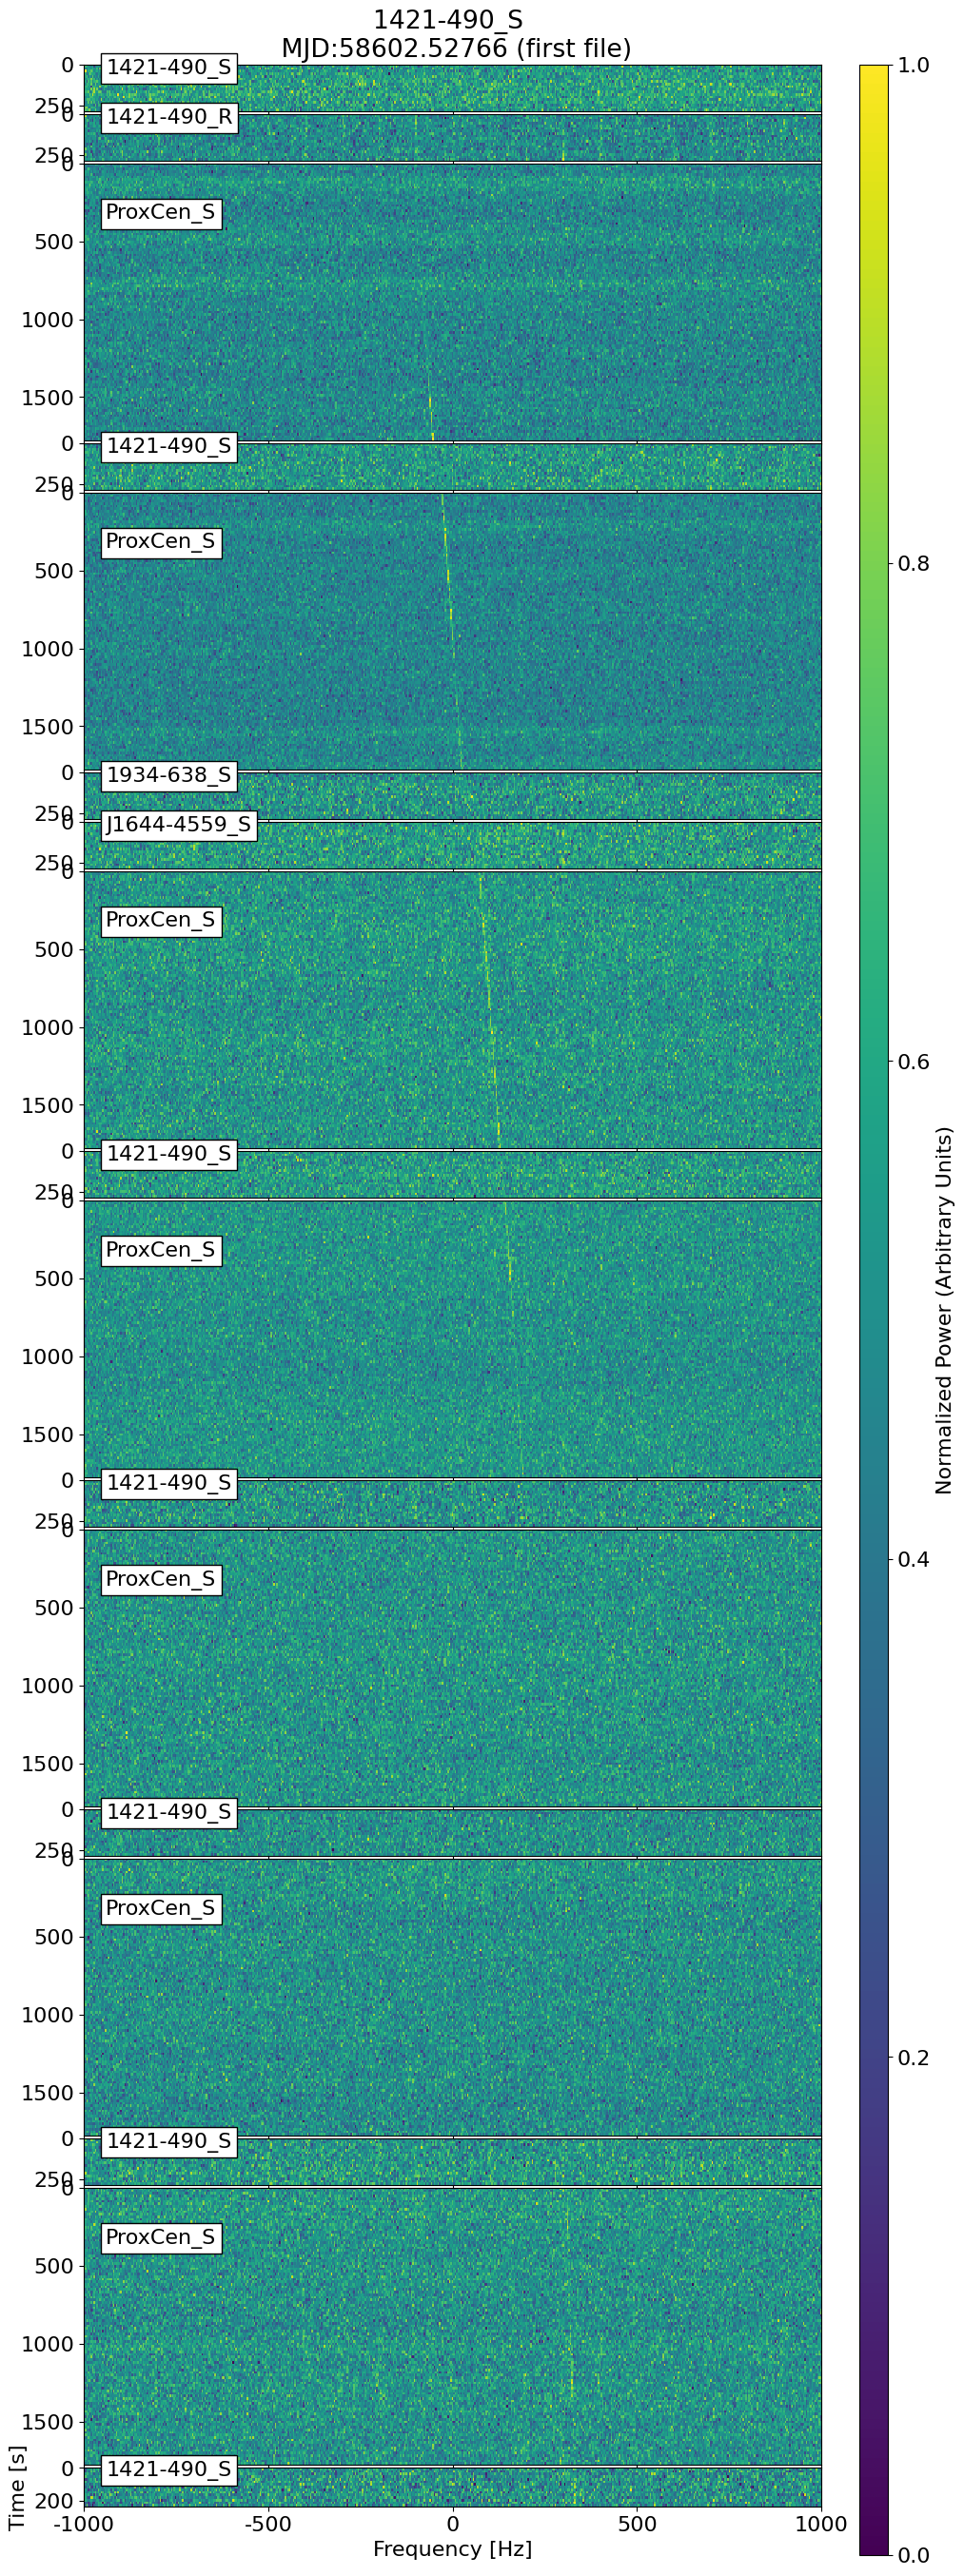

In [13]:
bl.stax.make_waterfall_plots(file_list=file_list,
                             plot_dir='data/',
                             plot_dpi=100,
                             height_ratios=height_ratios,
                             f_start=982.0015,
                             f_stop=982.0035)

In [14]:
filename = es.DRIFTS.loc[0]['filename']
full_path = f'{es.DATA_PREFIX}/{filename}'.replace('blcxx', 
                                                   es.META.loc[0]['node'])

container = bl.Waterfall(full_path, load_data=False).container
tchans = container.file_shape[0]
df = container.header['foff']
dt = container.header['tsamp']
df, dt

(3.814697265625e-06, 16.777216)

In [53]:
all_y = np.load('intensity_data.npy', allow_pickle=True)
ts_info = np.load('ts_info.npy', allow_pickle=True).item()

candidate = all_y[0]['signal']

synth_file_list = []
for i, ts in enumerate(ts_info['ts_list']):
    ys = candidate[i]['scaled_ys']
    noise_mean = candidate[i]['noise_mean']
    
    frame = stg.Frame(fchans=2000,
                      tchans=len(ts),
                      df=df*u.MHz,
                      dt=dt,
                      fch1=982.0015*u.MHz,
                      ascending=True)
    if noise_mean is None:
        filename = es.DRIFTS['filename'].loc[i]
        full_path = f'{es.DATA_PREFIX}/{filename}'.replace('blcxx', 
                                                           es.META.loc[0]['node'])
        fr = stg.Frame(bl.Waterfall(full_path, f_start=982.0015, f_stop=982.0035))
        noise_mean = fr.noise_mean
    frame.add_noise(noise_mean)
    
    if ys is not None:
        # Make sure values are nonnegative
        frame.add_signal(stg.constant_path(f_start=candidate[i]['center_freq']*u.MHz,
                                            drift_rate=candidate[i]['drift_rate']),
                         frame.noise_std * np.maximum(ys, 0) / 2,
                         stg.sinc2_f_profile(width=6*u.Hz),
                         stg.constant_bp_profile(level=1))
    fn = f'data/synth_blc1_{i}.fil'
    frame.save_fil(fn)
    synth_file_list.append(fn)

blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec
blimpy.waterfall INFO     Conversion time: 0.01sec
blimpy.waterfall INFO     Conversion time: 0.00sec


stax            INFO     Processing: data/synth_blc1_0.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_1.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_2.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_3.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_4.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_5.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_6.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_7.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Processing: data/synth_blc1_8.fil, freq lowest=982.0015, highest=982.0034950866699
stax            INFO     Pro

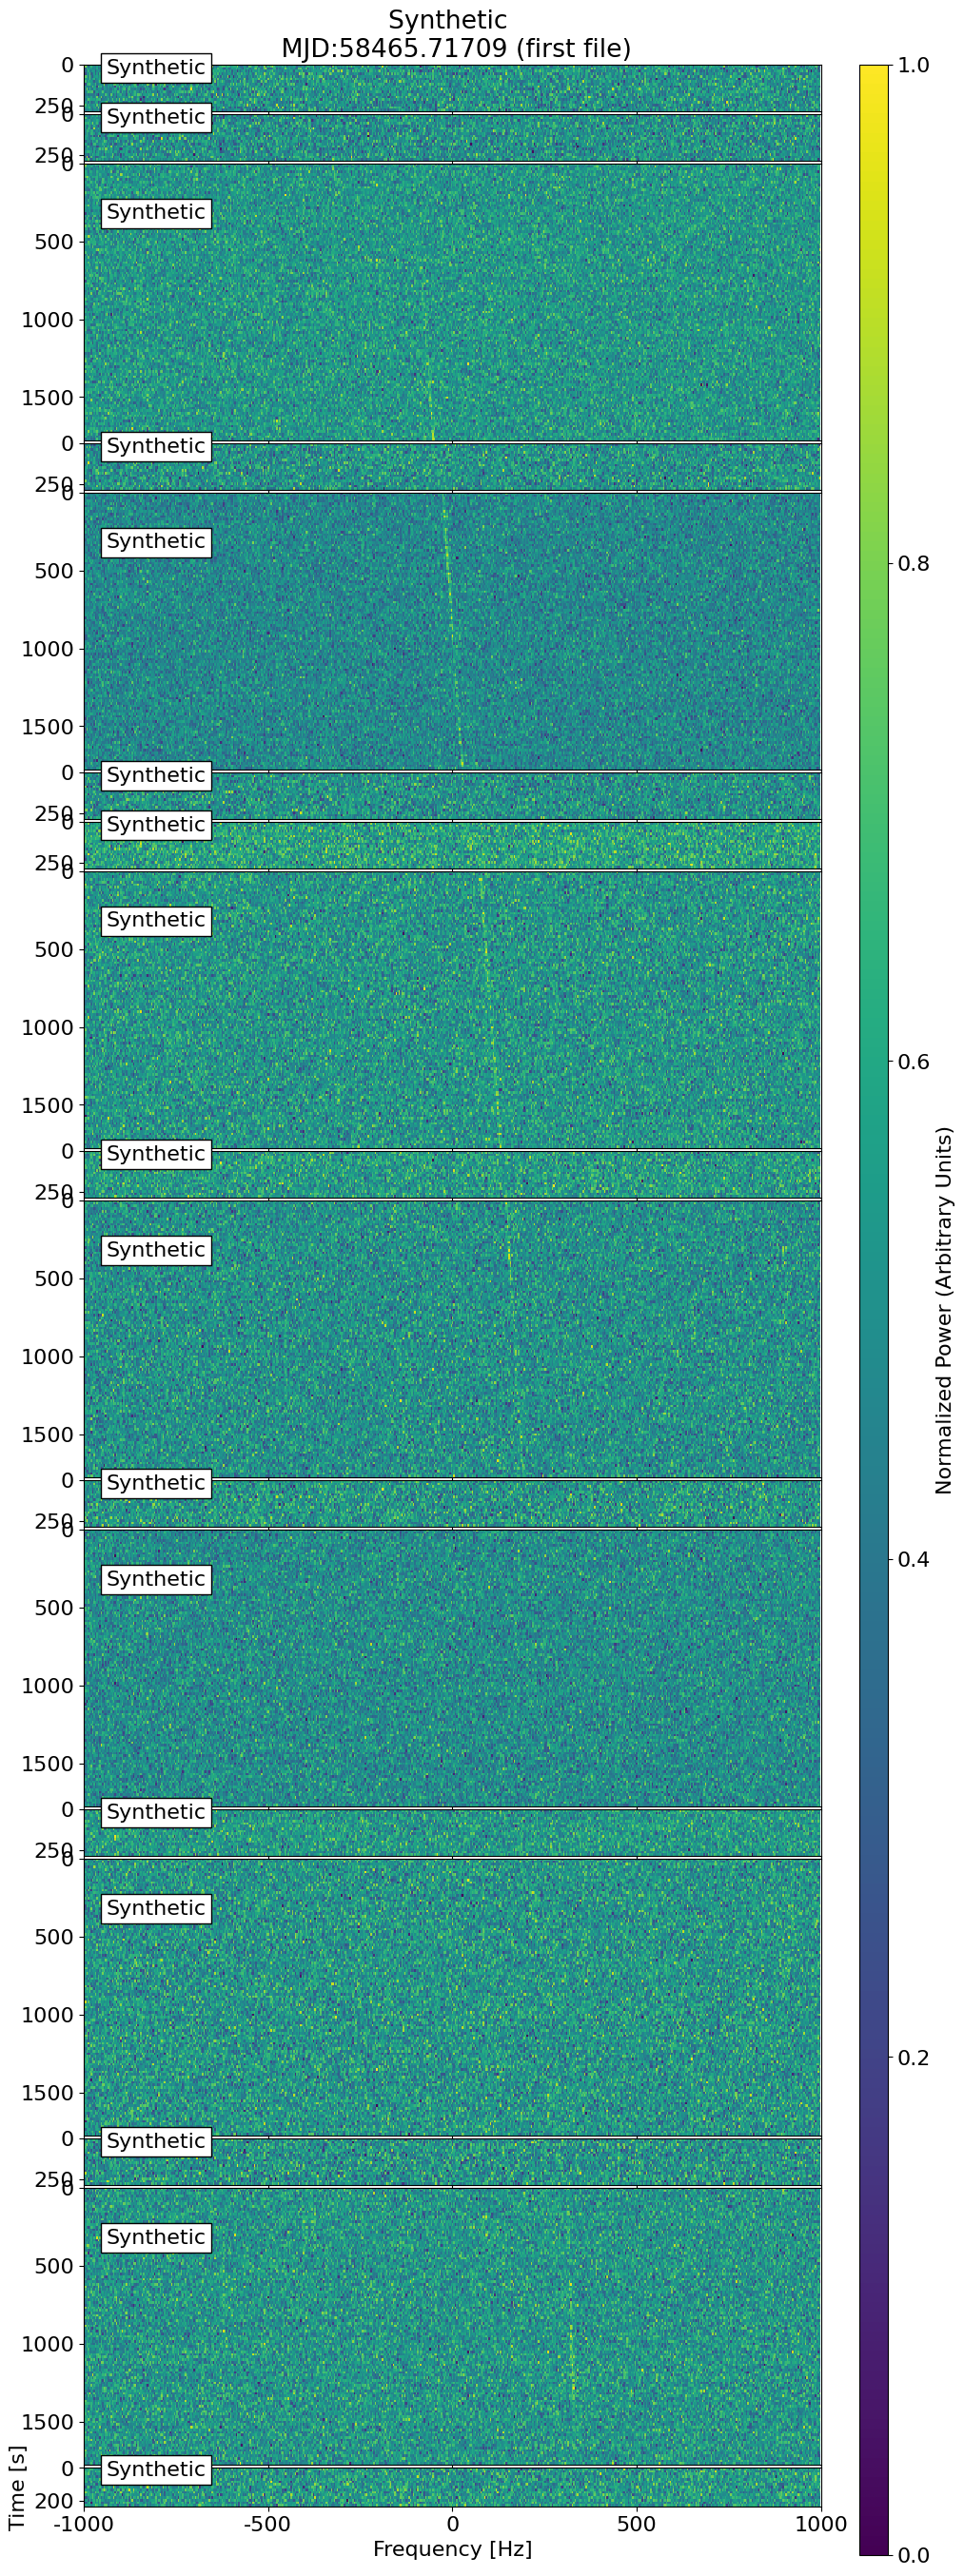

In [54]:
bl.stax.make_waterfall_plots(file_list=synth_file_list,
                             plot_dir='data/synth_',
                             plot_dpi=100,
                             height_ratios=height_ratios,
                             f_start=982.0015,
                             f_stop=982.0035)